# Title: 'Tree-based ML for insurance pricing'
## Based on : Book Interpretation Tools for ML methods and 'Tree-based ML for insurance pricing'  on Github by 'Roel Henckaerts, Marie-Pier Côté, Katrien Antonio and Roel Verbelen'

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from collections import defaultdict
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder
from scipy.special import gamma
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

from sklearn.tree import plot_tree


/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## DATA


In [2]:
mtpl_orig = pd.read_csv('Assignment.csv')
df2 = pd.read_excel('inspost.xls')
# Merge df1 and df2 based on the common column 'CODPOSS'
mtpl = mtpl_orig.merge(df2, left_on='CODPOSS', right_on='CODPOSS')

mtpl

,AGEPH,CODPOSS,duree,lnexpo,nbrtotc,nbrtotan,chargtot,agecar,sexp,fuelc,split,usec,fleetc,sportc,coverp,powerc,INS,COMMUNE,LAT,LONG
0,64,1000,1.000000,0.000000,0,0.000000,0.000000,2-5,Female,Petrol,Once,Private,No,No,MTPL+,66-110,21004,BRUSSEL,50.833333,4.350000
1,28,1000,0.046575,-3.066684,1,21.470588,155.974606,6-10,Female,Petrol,Twice,Private,No,No,MTPL,66-110,21004,BRUSSEL,50.833333,4.350000
2,58,1000,0.402740,-0.909465,0,0.000000,0.000000,>10,Female,Petrol,Thrice,Private,No,No,MTPL,<66,21004,BRUSSEL,50.833333,4.350000
3,62,1000,1.000000,0.000000,0,0.000000,0.000000,>10,Female,Petrol,Once,Private,No,No,MTPL+,<66,21004,BRUSSEL,50.833333,4.350000
4,41,1000,1.000000,0.000000,1,1.000000,62.419590,6-10,Female,Petrol,Monthly,Private,No,No,MTPL,66-110,21004,BRUSSEL,50.833333,4.350000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163652,76,3320,1.000000,0.000000,0,0.000000,0.000000,6-10,Male,Petrol,Once,Private,No,No,MTPL,<66,24041,HOEGAARDEN,50.766667,4.883333
163653,42,4770,1.000000,0.000000,1,1.000000,516.337423,>10,Male,Gasoil,Once,Private,No,No,MTPL,<66,63001,AMEL,50.350000,6.166667
163654,48,4770,1.000000,0.000000,0,0.000000,0.000000,>10,Male,Petrol,Monthly,Private,No,No,MTPL,<66,63001,AMEL,50.350000,6.166667
163655,27,4770,1.000000,0.000000,0,0.000000,0.000000,6-10,Male,Petrol,Twice,Private,No,No,MTPL,<66,63001,AMEL,50.350000,6.166667


In [3]:
# describe 

mtpl.describe()
print (mtpl.describe(include = 'object'))

        agecar    sexp   fuelc   split     usec  fleetc  sportc  coverp  \
count   163657  163657  163657  163657   163657  163657  163657  163657   
unique       4       2       2       4        2       2       2       3   
top       6-10    Male  Petrol    Once  Private      No      No    MTPL   
freq     67151  120434  113210   81479   155652  158428  162145   95409   

        powerc    COMMUNE  
count   163657     163657  
unique       3        583  
top        <66  CHARLEROI  
freq    119809       5038  


In [4]:

# Rename columns to lowercase
mtpl.columns = [col.lower() for col in mtpl.columns]

# Redefine split 
replacement_dict = {'Once': 1, 'Twice': 2, 'Thrice': 3, 'Monthly': 12}

# Replace values in the 'col1' column using the dictionary
mtpl['split'] = mtpl['split'].replace(replacement_dict)

# Calculate mean and frequency
m = mtpl['nbrtotc'].mean()
freq = mtpl['nbrtotc'].sum() / mtpl['duree'].sum()

# Print dimensions
print(mtpl.shape)

(163657, 20)


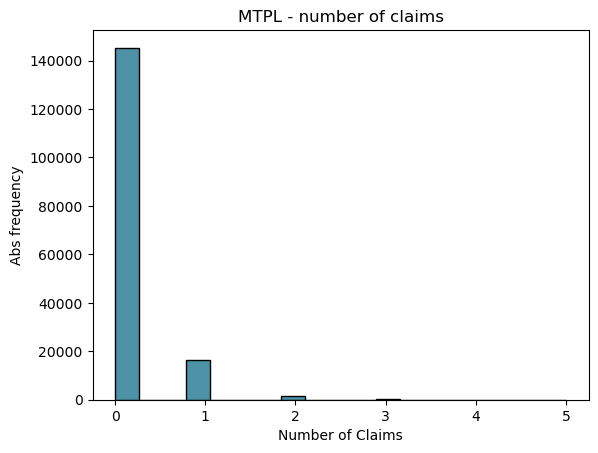

In [5]:
# Visualization
KULbg = "#116E8A"
g = sns.histplot(mtpl['nbrtotc'], color=KULbg)
g.set(xlabel='Number of Claims', ylabel='Abs frequency', title='MTPL - number of claims')
plt.show()

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:416: UserWarning: `bins` cannot be 'auto' when using weights. Setting `bins=10`, but you will likely want to adjust.
  warnings.warn(msg, UserWarning)


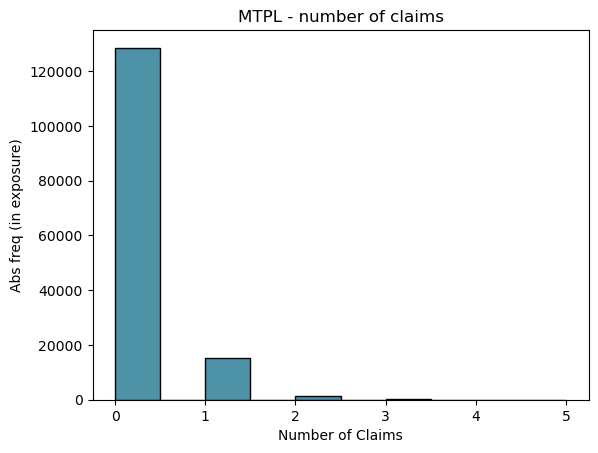

In [6]:
g = sns.histplot(mtpl, x='nbrtotc', weights='duree', color=KULbg)
g.set(xlabel='Number of Claims', ylabel='Abs freq (in exposure)', title='MTPL - number of claims')
plt.show()

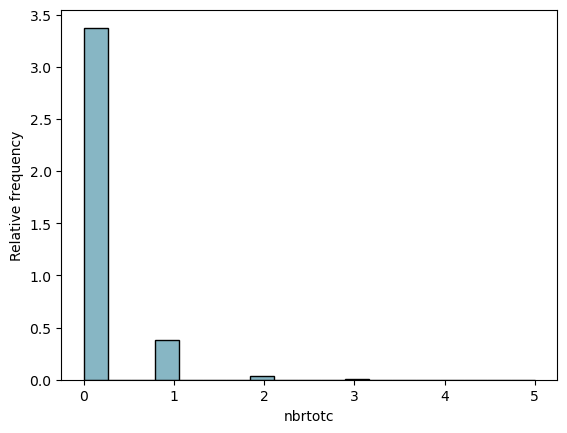

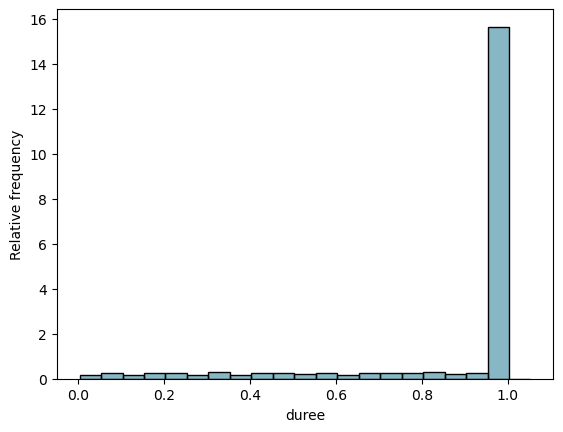

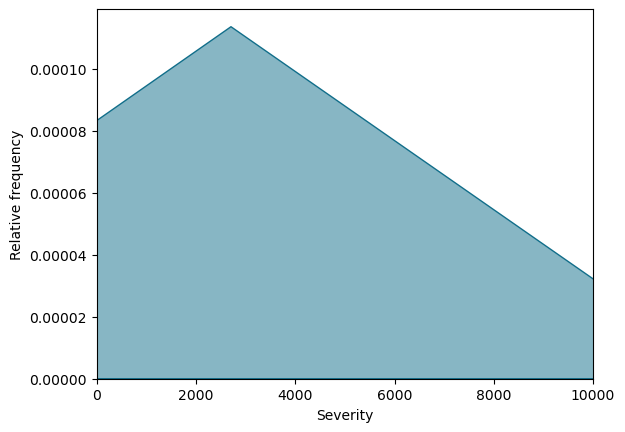

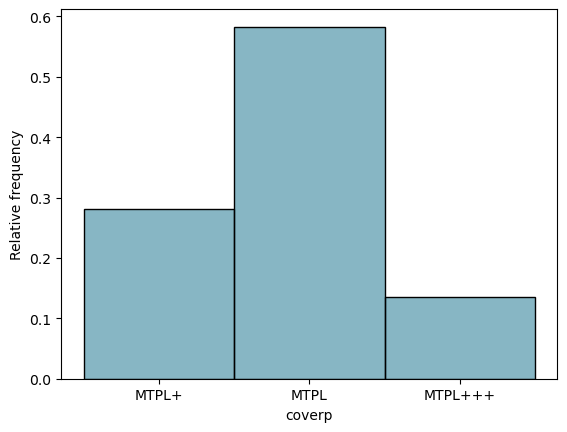

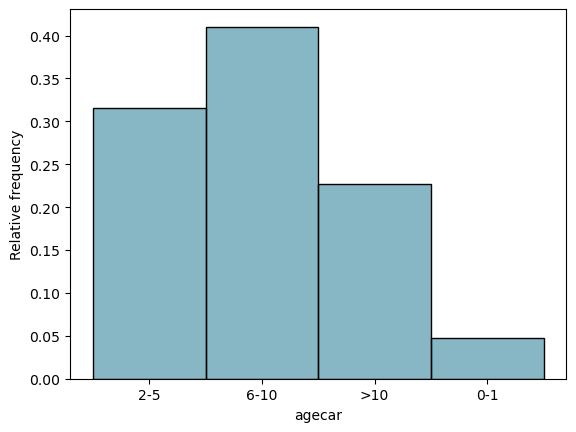

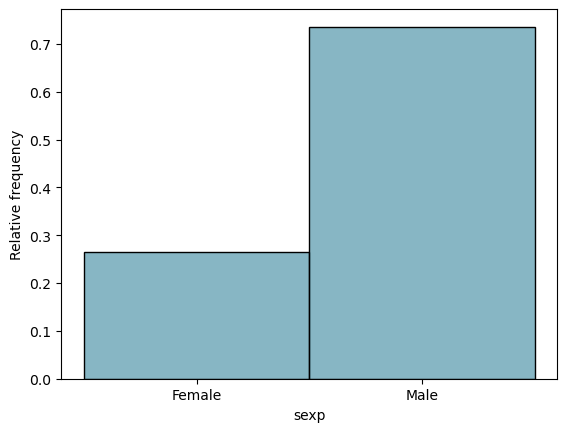

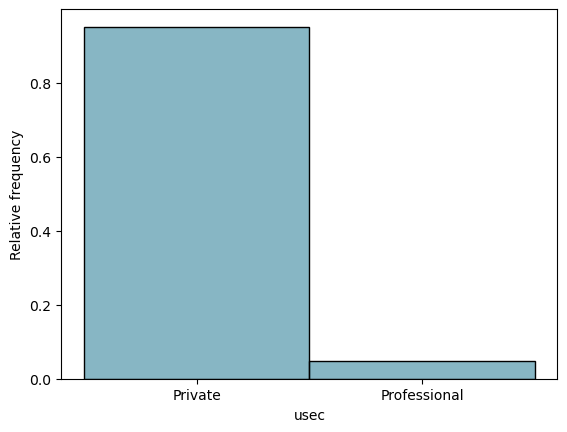

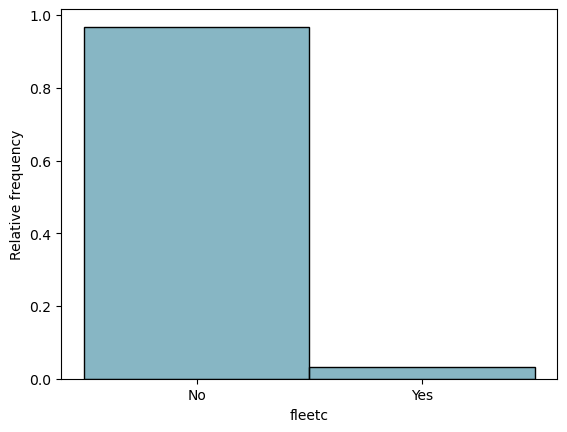

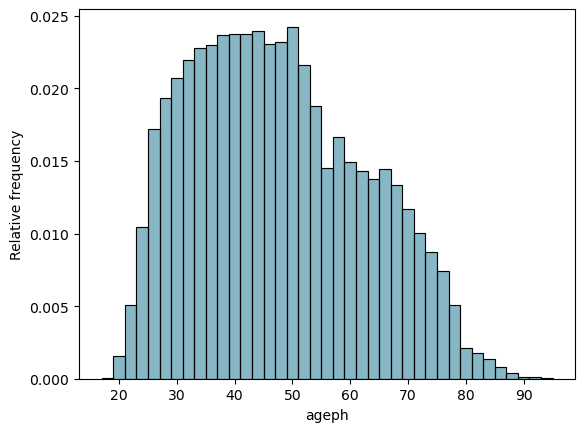

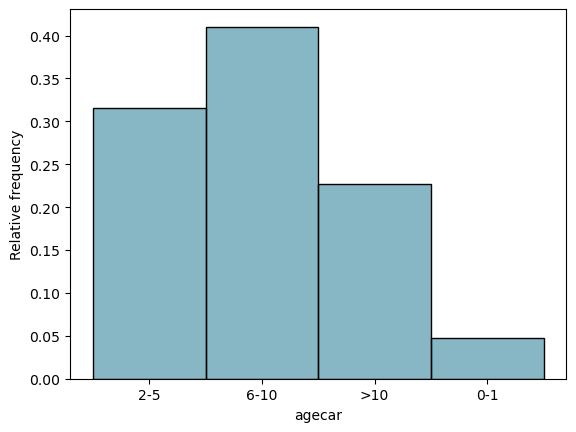

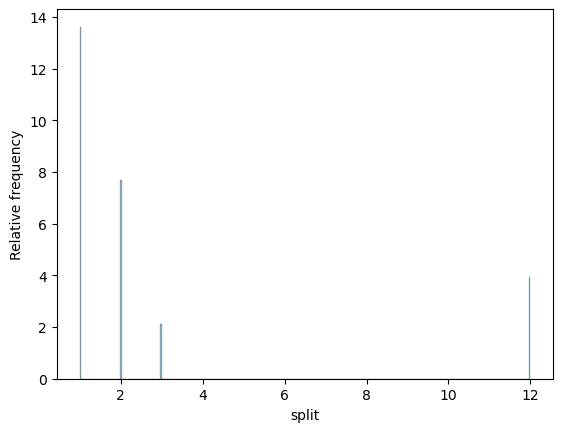

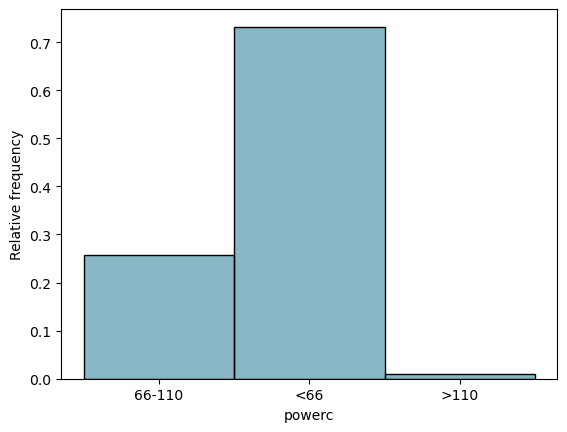

In [7]:
# Wrapper functions
def ggplot_bar(DT, variable, xlab):
    g = sns.histplot(data=DT, x=variable, stat='density', color=KULbg, alpha=0.5)
    g.set(xlabel=xlab, ylabel='Relative frequency')
    plt.show()

def ggplot_hist(DT, variable, xlab, binwidth):
    g = sns.histplot(data=DT, x=variable, binwidth=binwidth, stat='density', color=KULbg, alpha=0.5)
    g.set(xlabel=xlab, ylabel='Relative frequency')
    plt.show()
# Targets: frequency, exposure, and total severity
ggplot_bar(mtpl, 'nbrtotc', 'nbrtotc')
ggplot_hist(mtpl, 'duree', 'duree', 0.05)

mtpl_sev = mtpl[(mtpl['chargtot'] > 0)]# & (mtpl['avg'] <= 81000)]  # Filter data
g = sns.kdeplot(data=mtpl_sev['chargtot'], color=KULbg, fill=True, alpha=0.5)
g.set(xlabel='Severity', ylabel='Relative frequency')
plt.xlim(0, 1e4)
plt.show()

# Bar plots of factor variables
for column in ['coverp', 'agecar', 'sexp', 'usec', 'fleetc']:
    ggplot_bar(mtpl, column, column)

# Histograms of continuous variables
ggplot_hist(mtpl, 'ageph', 'ageph', 2)
ggplot_hist(mtpl, 'agecar', 'agecar', 1)
ggplot_bar(mtpl, 'split', 'split')
ggplot_hist(mtpl, 'powerc', 'powerc', 10)

Our graphs shows that we are modeling integer-valued frequency
data or right-skewed severity data, this motivates the use of loss functions which are not based on the squared error loss. 
#### For claim frequency modeling involves count data, typically assumed to be Poisson distributed 
Therefore, an appropriate loss function is the Poisson deviance, defined as follows:
 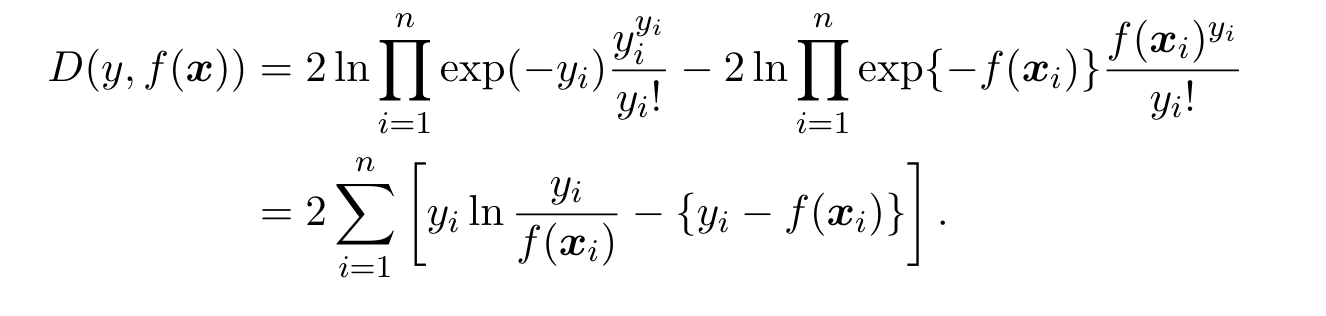
 
#### For severity modeling involves count data, typically assumed to be Gamma distributed 
Right-skewed and long-tailed severity data is typically assumed to be gamma.
The gamma deviance is defined as follows:
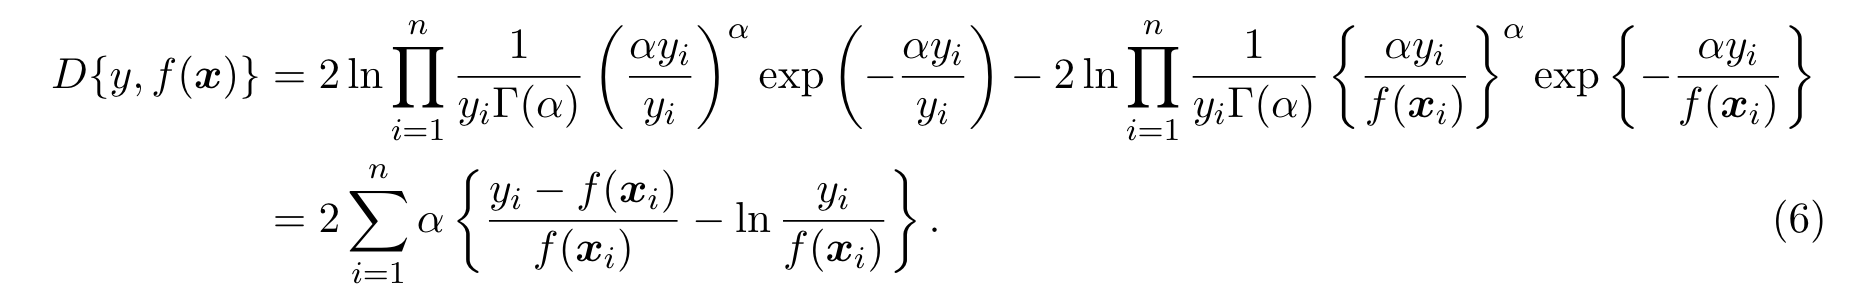

So we can define our loss functions based on the appropriate deviance.

             ageph   codposs     duree    lnexpo   nbrtotc  nbrtotan  \
ageph     1.000000 -0.029827  0.099901  0.078857 -0.069035 -0.038769   
codposs  -0.029827  1.000000  0.070874  0.061599 -0.017948 -0.010157   
duree     0.099901  0.070874  1.000000  0.913371  0.052203 -0.068061   
lnexpo    0.078857  0.061599  0.913371  1.000000  0.056768 -0.081085   
nbrtotc  -0.069035 -0.017948  0.052203  0.056768  1.000000  0.471175   
nbrtotan -0.038769 -0.010157 -0.068061 -0.081085  0.471175  1.000000   
chargtot -0.010823  0.001296  0.000843  0.002014  0.100368  0.058756   
split    -0.114590 -0.207059 -0.256008 -0.220810  0.016326  0.022017   
ins       0.026376  0.377525  0.018485  0.017844 -0.019480 -0.012680   
lat      -0.052471 -0.150414  0.004351  0.000507  0.010329  0.006249   
long      0.049076 -0.533458 -0.039023 -0.033159 -0.004210 -0.005207   

          chargtot     split       ins       lat      long  
ageph    -0.010823 -0.114590  0.026376 -0.052471  0.049076  
codposs   0.0

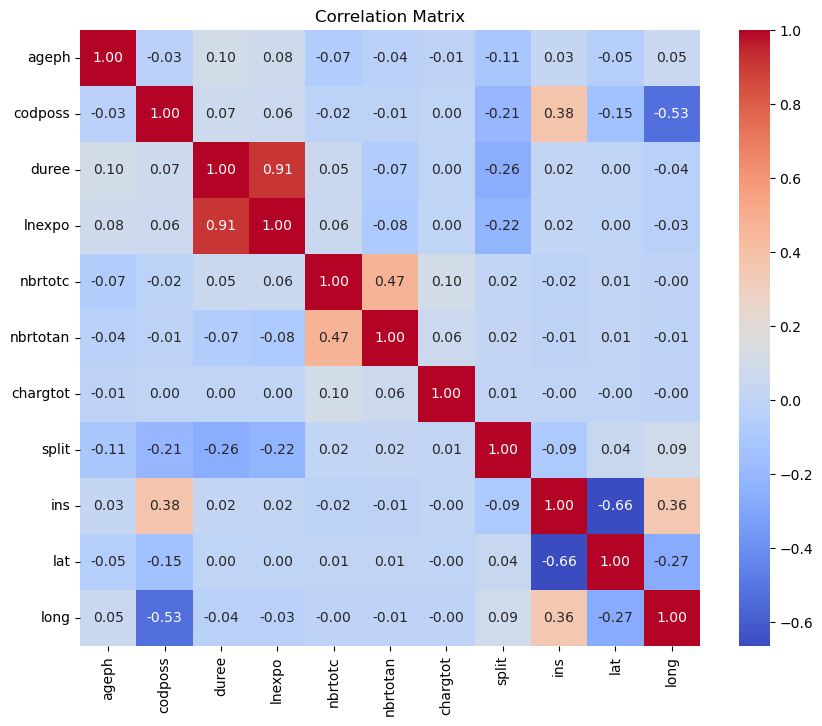

In [8]:
# Assuming df is your DataFrame
correlation_matrix = mtpl.corr()

# Print correlation matrix
print(correlation_matrix)

# Visualize correlation matrix (optional)


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

Here we can see a high correlation between duree and ln expo so we drop the ln expo collumn in our mtpl.


In [9]:

#Here we can see a high correlation between duree and ln expo so we drop the ln expo collumn in our mtpl.
mtpl = mtpl.drop("lnexpo", axis=1)
#mtpl

In [10]:
mtpl1 = mtpl
mtpl1.columns

Index(['ageph', 'codposs', 'duree', 'nbrtotc', 'nbrtotan', 'chargtot',
       'agecar', 'sexp', 'fuelc', 'split', 'usec', 'fleetc', 'sportc',
       'coverp', 'powerc', 'ins', 'commune', 'lat', 'long'],
      dtype='object')

### For ML applications, we need to transform all our columns to a numerical input. We will transform our categorical features to integers:

In [11]:
# map string values to integers for certain columns

cats1 = [col for col in mtpl1.columns if mtpl1[col].dtype == 'object']

# Identify columns with strings

label_encoder = LabelEncoder()
for col in cats1:
    mtpl1[col] = label_encoder.fit_transform(mtpl1[col])



#unique_values = mtpl['powerc'].unique()
#print(type(unique_values))
#print(unique_values)
#mltp1['powerc'].unique()
#print (cats1,mtpl.describe(include = 'object'))

mtpl1.dtypes

ageph         int64
codposs       int64
duree       float64
nbrtotc       int64
nbrtotan    float64
chargtot    float64
agecar        int64
sexp          int64
fuelc         int64
split         int64
usec          int64
fleetc        int64
sportc        int64
coverp        int64
powerc        int64
ins           int64
commune       int64
lat         float64
long        float64
dtype: object

## Train and test split

#### Assuming independence between the frequency and the severity

In [12]:
# Split data into training and testing sets
X = mtpl1.drop(columns=['nbrtotc','chargtot','duree', 'nbrtotan']) # 
y = mtpl1['nbrtotc']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Deviance loss function for poisson and gamma
When using an exposure-to-risk measure ei
, f(xi) is replaced by ei
·f(xi) such that the exposure
is taken into account in the expected number of claims. This site https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/metrics/_regression.py teaches us how Deviance loss function for poisson and gamma are constructed and how to consider the exposure as weights.


In [54]:
# instead of contructing them from scratch we import them sklearn.metrics
from sklearn.metrics import mean_poisson_deviance
from sklearn.metrics import mean_gamma_deviance

In [69]:
import numpy as np
from sklearn.utils.validation import check_consistent_length, column_or_1d

def mean_poisson_deviance1(y_true, y_pred, *, sample_weight=None):
    
    # Ensure y_pred is non-zero
    #if (y_pred == 0).any():
        #raise ValueError("Input array y_pred must not contain zero values.")
    if (y_pred > 0).any(): 
        print(y_pred)
        # Calculate Poisson deviance with epsilon to avoid zero division or log of zero
        dev = 2 * (y_true * np.log(y_true / y_pred) - y_true + y_pred)

        # Apply sample weights if provided
        if sample_weight is not None:
            dev *= sample_weight

        # Calculate mean deviance
    mean_deviance = np.mean(dev)

    return mean_deviance

In [70]:
def poisson_deviance(y_true, y_pred):
    # Poisson distribution
    
    #exposure = X_train['duree']
    #n_samples = len(y_true)
    dev = 2 * (y_true * np.log(y_true / y_pred) - y_true + y_pred)#2 * (xlogy(y_true, y_true / y_pred) - y_true + y_pred)
    deviance = 2 * np.sum(y_true * np.log(y_true / y_pred*exposure) - (y_true - y_pred*exposure))
    return deviance # (2*(y_true * np.log(y_true/y_pred) - (y_true-y_pred))).sum()

In [71]:
def gamma_deviance(y_true, y_pred, alpha):
    exposure = X_train['duree']
    n_samples = len(y_true)
    deviance = 2 * np.sum(
        (alpha * (y_true - y_pred*exposure) / y_pred*exposure) - np.log(y_true / y_pred*exposure) - np.log(gamma(alpha))
    )
    return deviance / n_samples

## Frequency modeling


#### 4.2 Claim frequency <a name="four-two"></a>
We start our modeling efforts by building a claim frequency `DecisionTreeRegressor` model for the MTPL dataset. The [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) teaches us that there is a `poisson criterion` which uses reduction in Poisson deviance to find splits

In [72]:
# claim frequency (nclaims/expo) as target
y_mtpl_freq = np.array(mtpl1.nbrtotc/mtpl1.duree)
# exposure as weights
w_mtpl_freq = np.array(mtpl.duree)
y_mtpl_freq

array([ 0.        , 21.47058822,  0.        , ...,  0.        ,
        0.        ,  0.        ])

### Decision tree

In [73]:
# cols to retain as features
feat_cols = X.columns
# subset the data
X_mtpl_freq = X[feat_cols]
# print the shape
print(X_mtpl_freq.shape)
# show the features
X_mtpl_freq

(163657, 15)


,ageph,codposs,agecar,sexp,fuelc,split,usec,fleetc,sportc,coverp,powerc,ins,commune,lat,long
0,64,1000,1,0,1,1,0,0,0,1,0,21004,85,50.833333,4.350000
1,28,1000,2,0,1,2,0,0,0,0,0,21004,85,50.833333,4.350000
2,58,1000,3,0,1,3,0,0,0,0,1,21004,85,50.833333,4.350000
3,62,1000,3,0,1,1,0,0,0,1,1,21004,85,50.833333,4.350000
4,41,1000,2,0,1,12,0,0,0,0,0,21004,85,50.833333,4.350000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163652,76,3320,2,1,1,1,0,0,0,0,1,24041,232,50.766667,4.883333
163653,42,4770,3,1,0,1,0,0,0,0,1,63001,9,50.350000,6.166667
163654,48,4770,3,1,1,12,0,0,0,0,1,63001,9,50.350000,6.166667
163655,27,4770,2,1,1,2,0,0,0,0,1,63001,9,50.350000,6.166667


In [74]:
#X_mtpl_freq = xgb.DMatrix(X_train, label=y_train)
# initialize a tree of depth 2
tree_freq = DecisionTreeRegressor(criterion='poisson', max_depth=10, min_samples_split=10000, min_samples_leaf=5000)
# fit the tree to our target 
tree_freq.fit(X=X_mtpl_freq, y=y_mtpl_freq) #, sample_weight=w_mtpl_freq??
# print the tree
tree_freq

DecisionTreeRegressor(criterion='poisson', max_depth=10, min_samples_leaf=5000,
                      min_samples_split=10000)

In [75]:

train_predictions = tree_freq.predict(X_mtpl_freq)

# Calculate poisson_deviance on the training set
#exposure = mtpl1['duree']
poisson_dev1 = mean_poisson_deviance(y_mtpl_freq, train_predictions)
print("Training poisson_deviance:", poisson_dev1)
poisson_dev2 = mean_poisson_deviance1(y_mtpl_freq, train_predictions,  sample_weight=None)
print("Training poisson_deviance:", poisson_dev2)

Training poisson_deviance: 0.7763210991631708
[0.13952017 0.18579559 0.11280473 ... 0.18579559 0.18579559 0.18579559]
Training poisson_deviance: nan


/var/folders/n3/j9s0z6s92fd1_xkmg3xk0twh0000gn/T/ipykernel_17594/445048135.py:12: RuntimeWarning: divide by zero encountered in log
  dev = 2 * (y_true * np.log(y_true / y_pred) - y_true + y_pred)
/var/folders/n3/j9s0z6s92fd1_xkmg3xk0twh0000gn/T/ipykernel_17594/445048135.py:12: RuntimeWarning: invalid value encountered in multiply
  dev = 2 * (y_true * np.log(y_true / y_pred) - y_true + y_pred)


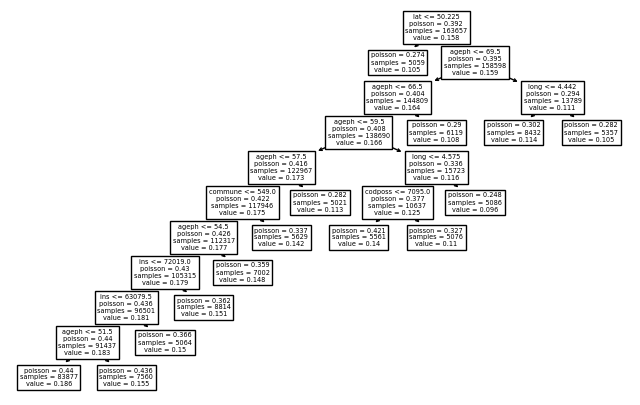

In [113]:
# plot the tree structure
plt.figure(figsize=(8, 5), dpi=100)
plot_tree(tree_freq, feature_names=feat_cols);

We fit a Poisson regression tree for claim frequency with the `rpart()` function and `method = 'poisson'` from the `distRforest` package

### Gradient boosting machine

In [76]:
from sklearn.metrics import mean_absolute_error


# Create DMatrix with enable_categorical=True
dtrain = xgb.DMatrix(data=X_mtpl_freq, label=y, enable_categorical=True)

#First, we create our feature matrix with all the MTPL features:

dtrain = xgb.DMatrix(X_mtpl_freq, label=y_mtpl_freq)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set parameters for xgboost Poisson regression
params = {
    'objective': 'count:poisson',  # Poisson regression objective
    'eval_metric': 'mae'            # Mean Absolute Error (MAE) as evaluation metric
}

# Train the model
num_boost_round = 100
bst = xgb.train(params, dtrain, num_boost_round)

# Make predictions
y_pred = bst.predict(dtest)

# Evaluate model
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 0.23400909060951025


### Grid search cross-validation

## Severity modeling


### Gradient boosting machine

### Grid search cross-validation

## Prediction functions
Now all ML models are fit, we can start analyzing them. To streamline this process, we define a predict function `predict_model` that can be applied to the different models in a uniform way:


## Model interpretation

### Variable importance

### partial dependence plots (PDPs)

### individual conditional expectation (ICE)

## Interaction effects


## Statistical performance


## Economic lift
